In [1]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, Sequential, backend
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate, Lambda, Input, ZeroPadding2D, AveragePooling2D, DepthwiseConv2D, Reshape

In [2]:
import os
import pip
counter = 0
newpath = "/home/viplabgpu/Documentos/isic-unet/segmentation/Segmentation"
for file in os.listdir(newpath):
    if file.endswith(".png"):
        if file.find("_novice") > -1:
            counter = counter + 1
            os.rename(os.path.join(newpath, file), os.path.join(newpath, file.replace("_novice", "_expert")))
if counter == 0:
    print("No file has been found")

No file has been found


In [3]:
class DataGen(keras.utils.Sequence):  
    def __init__(self, ids, path, batch_size=20, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size#tamanho da sample do treinamento
        self.image_size = image_size#tamanho da img
        self.on_epoch_end()
        
    def __load__(self, id_name):
        
        image_path = os.path.join(self.path, "Images", id_name) + ".jpeg"
        mask_path = os.path.join(self.path, "segmentation/Segmentation", id_name) + "_expert.png"
        
        
        image = cv2.imread(image_path,1)#carregar
        image = cv2.resize(image, (self.image_size, self.image_size))#ajustar tamanho
        mask = np.zeros((self.image_size, self.image_size, 1))#128*128*1
        _mask = cv2.imread(mask_path, -1)#cv2.IMREAD_UNCHANGED
        _mask = cv2.resize(_mask, (self.image_size, self.image_size))#ajustar tamanho
        _mask = np.expand_dims(_mask, axis=-1)
        mask = np.maximum(mask, _mask)
        
        #normalizar
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
          _img, _mask = self.__load__(id_name)
          image.append(_img)
          mask.append(_mask)
         
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask   #array
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [4]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [5]:
BACKBONE = 'efficientnetb0'
BATCHS = 20
CLASSES = ['lesion']
LR = 0.001
EPOCHS = 30

preprocess_input = sm.get_preprocessing(BACKBONE)

In [7]:
image_size = 128
path = "/home/viplabgpu/Documentos/isic-unet/"
train_path = "/home/viplabgpu/Documentos/isic-unet/Images"
batch_size = 20   

train_ids = []
for files in os.walk(train_path):
   for name in files:
      train_ids.append(name)

train_ids = train_ids[2]#nome do arquivo
train_ids = [i.split('.', 1)[0] for i in train_ids]#-extensao .jpg

val_data_size = 2000#tamanho dataset validação

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]#dividido em 2

In [8]:
gen = DataGen(train_ids, path, batch_size=batch_size, image_size=image_size)#le o treinamento

x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(20, 128, 128, 3) (20, 128, 128, 1)


2


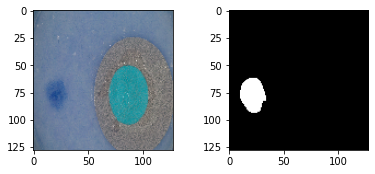

In [9]:
r = random.randint(0, len(x)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [10]:
train_gen = DataGen(train_ids, path)
valid_gen = DataGen(valid_ids, path,3,128)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

In [11]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

16809984/16804768 [==============================] - 3s 0us/step


In [12]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [13]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [14]:
hst = model.fit(
    train_gen, 
    steps_per_epoch=train_steps, 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_gen, 
    validation_steps=valid_steps,
)

Epoch 1/30
100/100 [==============================] - 236s 2s/step - loss: 0.4009 - iou_score: 0.6482 - f1-score: 0.7760 - val_loss: 0.9876 - val_iou_score: 0.5484 - val_f1-score: 0.6907
Epoch 2/30
100/100 [==============================] - 227s 2s/step - loss: 0.2290 - iou_score: 0.7327 - f1-score: 0.8421 - val_loss: 0.4565 - val_iou_score: 0.6282 - val_f1-score: 0.7602
Epoch 3/30
100/100 [==============================] - 227s 2s/step - loss: 0.1928 - iou_score: 0.7649 - f1-score: 0.8644 - val_loss: 0.2844 - val_iou_score: 0.6692 - val_f1-score: 0.7822
Epoch 4/30
100/100 [==============================] - 227s 2s/step - loss: 0.1659 - iou_score: 0.7961 - f1-score: 0.8845 - val_loss: 0.2310 - val_iou_score: 0.7144 - val_f1-score: 0.8176
Epoch 5/30
100/100 [==============================] - 227s 2s/step - loss: 0.1465 - iou_score: 0.8160 - f1-score: 0.8972 - val_loss: 0.2152 - val_iou_score: 0.7414 - val_f1-score: 0.8408
Epoch 6/30
100/100 [==============================] - 226s 2s/ste

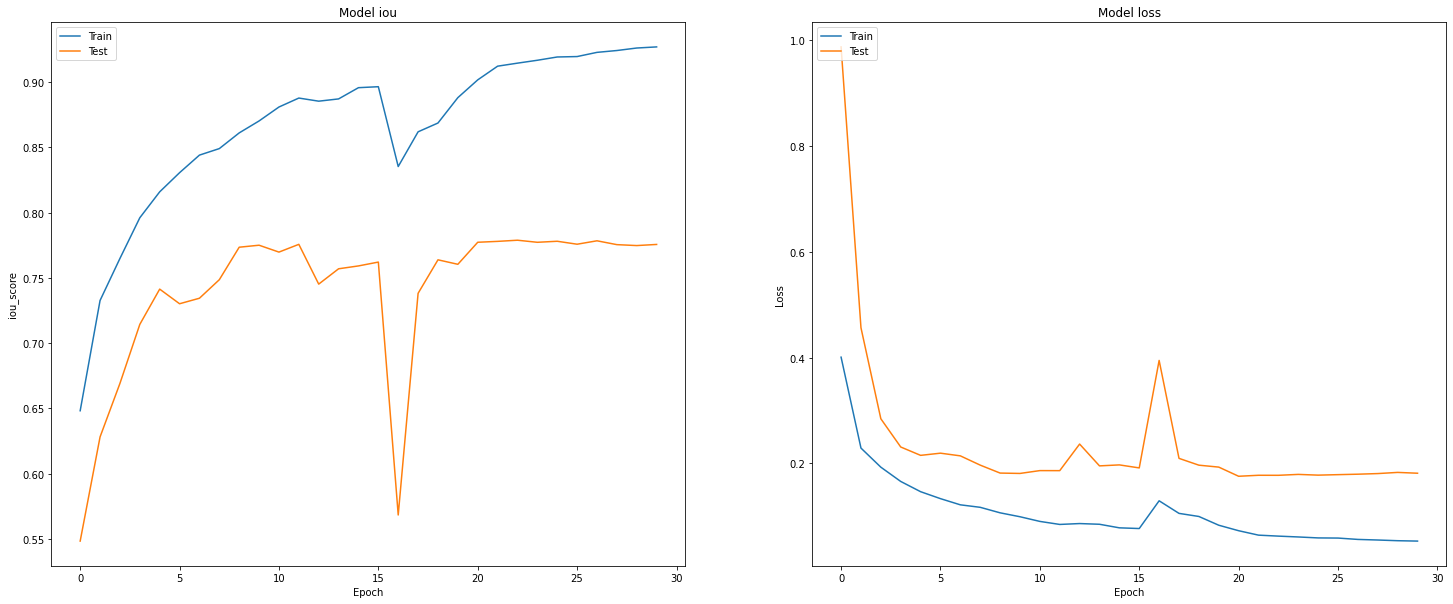

In [31]:
#Plot training & validation iou_score values
plt.figure(figsize=(25, 10))
plt.subplot(121)
plt.plot(hst.history['iou_score'])
plt.plot(hst.history['val_iou_score'])
plt.title('Model iou')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(hst.history['loss'])
plt.plot(hst.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

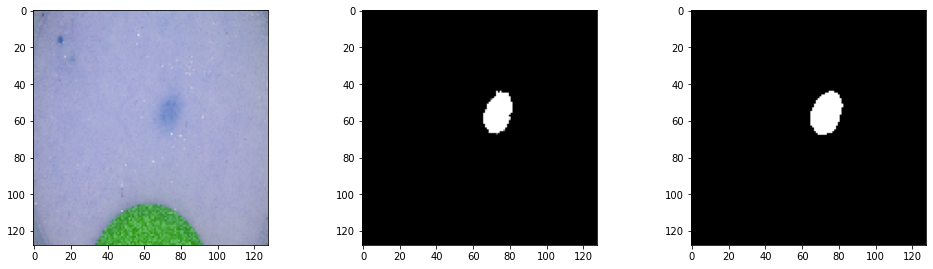

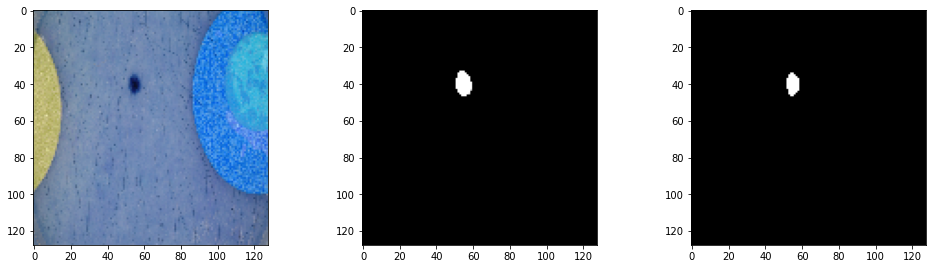

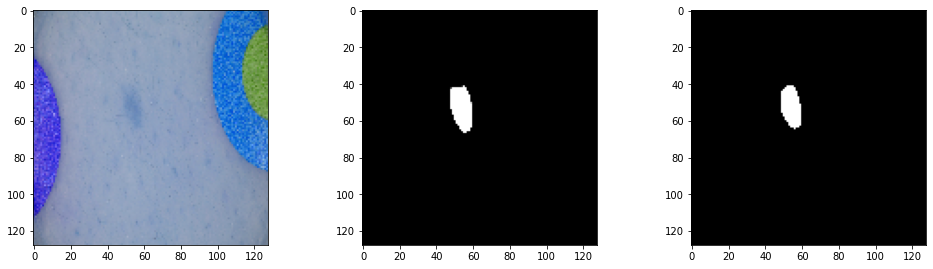

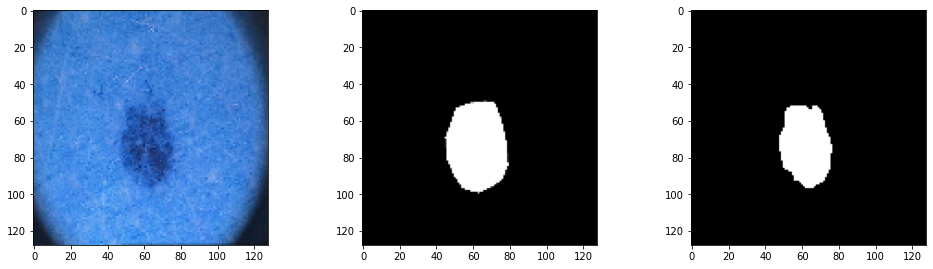

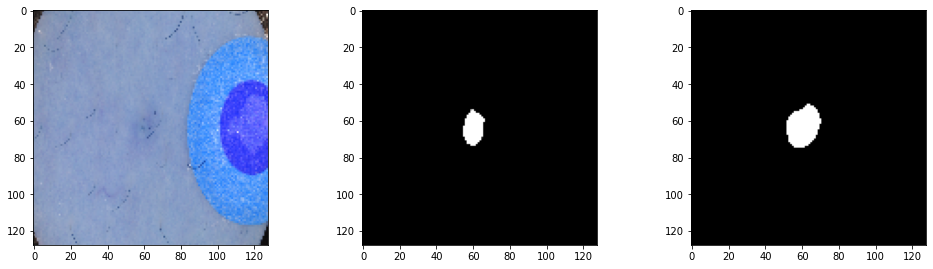

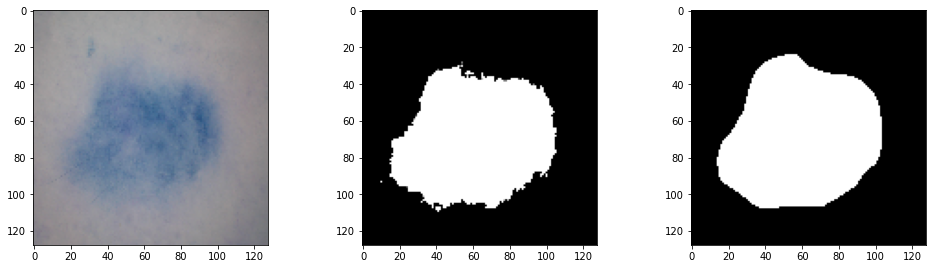

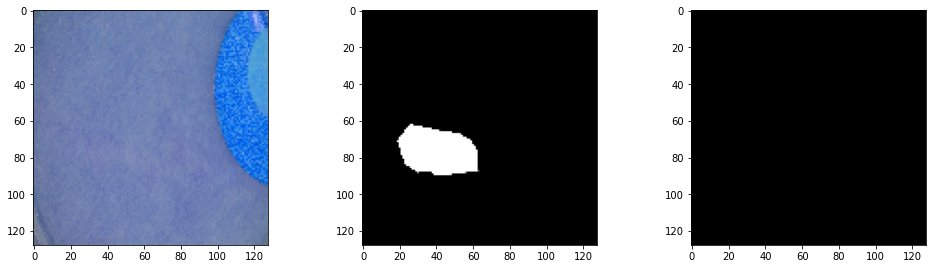

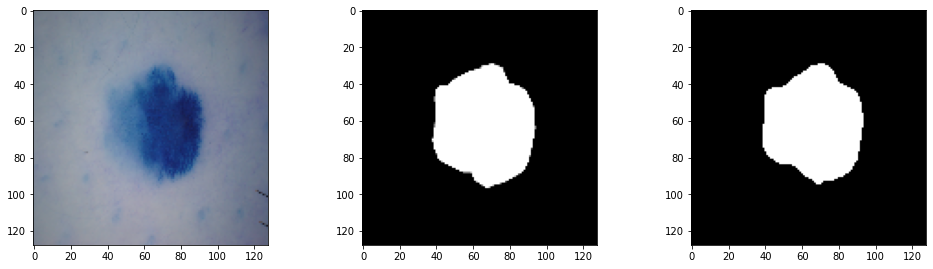

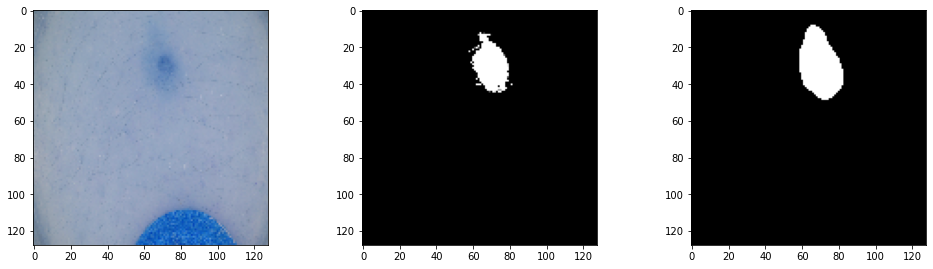

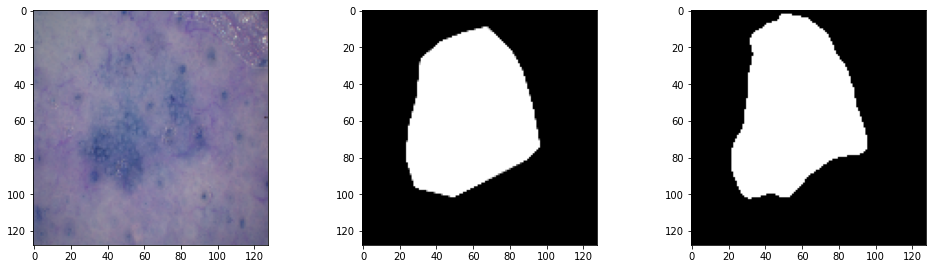

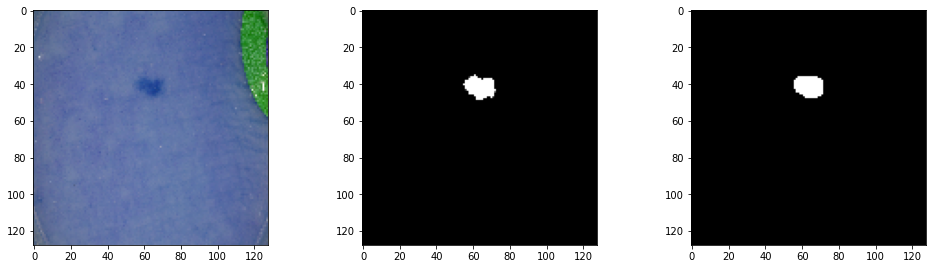

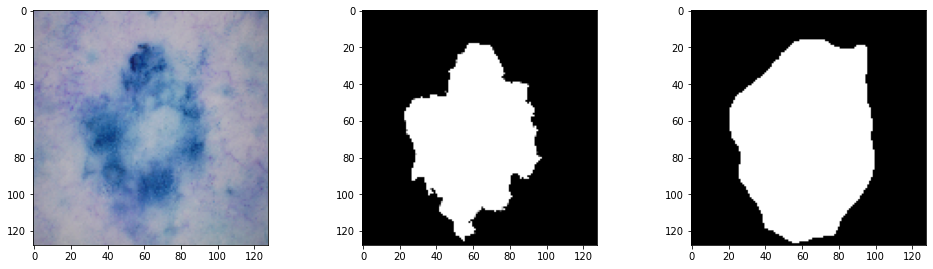

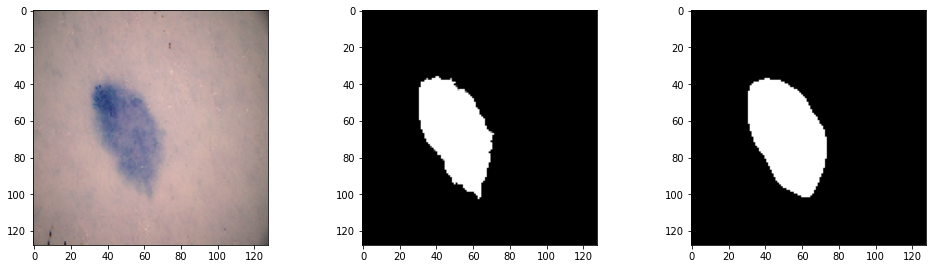

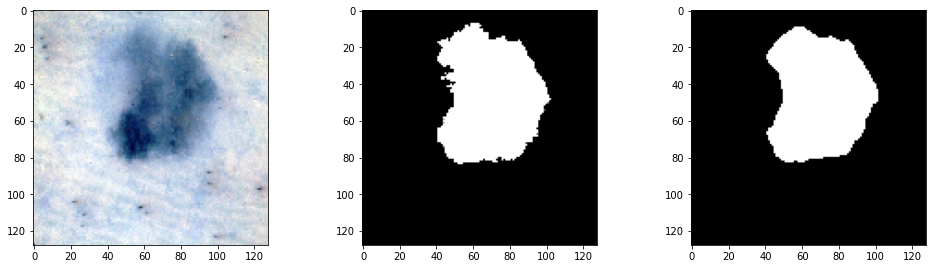

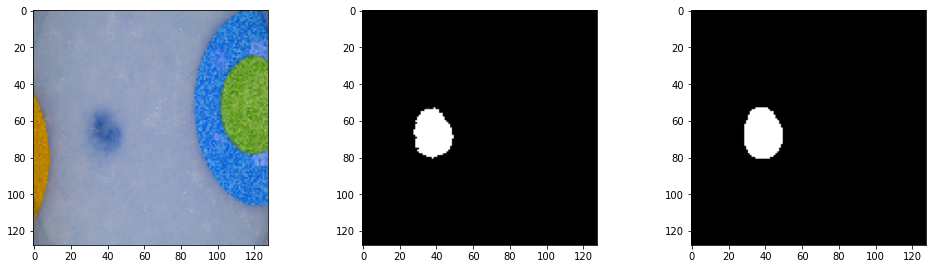

In [20]:
for i in range(0,15):
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    
    result = result > 0.5
    fig = plt.figure(figsize = (16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x[0])
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.utils import compute_class_weight as sk_compute_class_weight


def jaccard(y_true, y_pred):
    intersect = np.sum(y_true * y_pred) # Intersection points
    union = np.sum(y_true) + np.sum(y_pred)  # Union points
    return (float(intersect))/(union - intersect +  1e-7)


def compute_jaccard(y_true, y_pred):

    mean_jaccard = 0.
    thresholded_jaccard = 0.

    for im_index in range(y_pred.shape[0]):

        current_jaccard = jaccard(y_true=y_true[im_index], y_pred=y_pred[im_index])

        mean_jaccard += current_jaccard
        thresholded_jaccard += 0 if current_jaccard < 0.65 else current_jaccard

    mean_jaccard = mean_jaccard/y_pred.shape[0]
    thresholded_jaccard = thresholded_jaccard/y_pred.shape[0]

    return mean_jaccard

print(compute_jaccard(y, result))

0.7378585717445185


In [18]:
for i in range(0,100):
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    
    result = result > 0.5

    print(compute_jaccard(y, result))

(0.8980755364230794, 0.8980755364230794)
(0.7471766673771295, 0.7471766673771295)
(0.8899340844660711, 0.8899340844660711)
(0.7976641479076175, 0.7976641479076175)
(0.7563314294228927, 0.5841558925938064)
(0.857746403484081, 0.857746403484081)
(0.5382099777282053, 0.5382099777282053)
(0.6894015231608276, 0.6073989336230637)
(0.675957725265413, 0.3028920958552052)
(0.8364714042200934, 0.8364714042200934)
(0.7959419277571378, 0.7959419277571378)
(0.7560606868655689, 0.7560606868655689)
(0.9165190815808072, 0.9165190815808072)
(0.9236809110884275, 0.9236809110884275)
(0.7378585717445185, 0.5674052009313275)
(0.43836103774584195, 0.31272616752922905)
(0.44017949116631977, 0.24569878623086347)
(0.5551233229109348, 0.5551233229109348)
(0.7347536302862214, 0.531649122734779)
(0.7239172560339556, 0.54408466397882)
(0.8171744512856304, 0.8171744512856304)
(0.8107598732114306, 0.6167602414232287)
(0.6718962353108262, 0.5576950430843398)
(0.7255028229649775, 0.5099231128576304)
(0.420971501874140

In [26]:
for i in range(0,len(valid_gen)):
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    
    result = result > 0.5

    print(compute_jaccard(y, result))

0.8980755364230794
0.7471766673771295
0.8899340844660711
0.7976641479076175
0.7563314294228927
0.857746403484081
0.5382099777282053
0.6894015231608276
0.675957725265413
0.8364714042200934
0.7959419277571378
0.7560606868655689
0.9165190815808072
0.9236809110884275
0.7378585717445185
0.43836103774584195
0.44017949116631977
0.5551233229109348
0.7347536302862214
0.7239172560339556
0.8171744512856304
0.8107598732114306
0.6718962353108262
0.7255028229649775
0.42097150187414095
0.8932462059884392
0.8354841170160747
0.7384827453213608
0.4948110383482021
0.7634376886471453
0.875140523552817
0.8174396296978786
0.6931815618563002
0.8362972662692595
0.7651988170950833
0.8130400285259828
0.8408772305506219
0.5455706424031052
0.8645643900462812
0.8134388711831297
0.8911060154333633
0.840134506668433
0.8287502628475458
0.7641382142597101
0.81244949545587
0.891316275014394
0.6885277772023418
0.62288639770387
0.728127694282573
0.7461203199782185
0.8291336357871816
0.8402546952194857
0.8048947260523344


In [29]:
    x, y = valid_gen.__getitem__(400)
    result = model.predict(x)
    
    result = result > 0.5

    print(compute_jaccard(y, result))

UnboundLocalError: local variable 'batch_outputs' referenced before assignment

In [19]:
len(valid_gen)

667

In [30]:
    a, b = valid_gen.__getitem__(400)
    resultado = model.predict(x)
    
    resultado = resultado > 0.5
    fig = plt.figure(figsize = (16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(a[0])
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(b[0]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(np.reshape(resultado[0]*255, (image_size, image_size)), cmap="gray")

UnboundLocalError: local variable 'batch_outputs' referenced before assignment

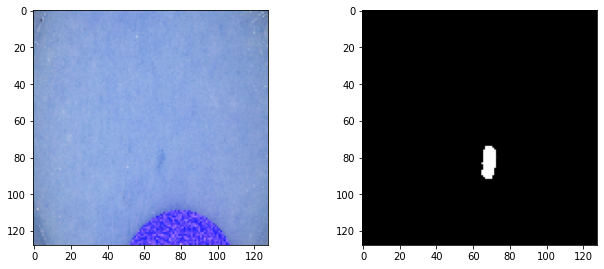

In [19]:
    x, y = valid_gen.__getitem__(24)

    fig = plt.figure(figsize = (16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x[0])
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")